In [1]:
import torch
import numpy as np
import os
from torch.utils.data import Dataset
#from skimage.transform import resize
import cv2 as cv
from torchsummary import summary
import pandas as pd
import psutil
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
Test_IMG_PATH = 'test/image'
Test_LABEL_PATH = 'test/label'
BATCHSIZE = 32
IMAGESIZE = 128

In [3]:
#https://www.kaggle.com/code/ivanshingel/cars-segmentation-research
class CityscapesDataset(Dataset):
    def __init__(self, transforms= None, train= True):
        # self.train = train
        # self.images_path = TRAIN_IMG_PATH
        # self.labels_path = TRAIN_LABEL_PATH
        if not train:
            self.images_path = Test_IMG_PATH
            self.labels_path = Test_LABEL_PATH

        self.len = len(os.listdir(self.images_path))

    def __getitem__(self, index):
        #load sample {img,,label}
        naming_label = int(os.listdir(self.images_path)[index].split('.')[0])
        image = np.asarray(np.load(os.path.join(self.images_path, f'{os.listdir(self.images_path)[index]}')),
                                            dtype= np.float32)
        image = cv.resize(image, (IMAGESIZE, IMAGESIZE), interpolation = cv.INTER_NEAREST)
        image = torch.from_numpy(image)
        image = image
        image = image.permute(2, 0, 1)

        labelSuffix = '_label'
        label = np.asarray(np.load(os.path.join(self.labels_path, f'{naming_label}{labelSuffix}.npy')))
        label = cv.resize(label, (IMAGESIZE, IMAGESIZE), interpolation = cv.INTER_NEAREST)
        label = torch.from_numpy(label)
        label = torch.Tensor(label)
        label = label.reshape(1, IMAGESIZE, IMAGESIZE)
        label = label + 1

        return image, label

    def __len__(self):
        return self.len

In [4]:
test_set = CityscapesDataset(train=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCHSIZE, shuffle=False)

In [5]:
class ConvLayer(torch.nn.Module):
    """Convelution layer
       convelution layers for one step on the "stairs"
    """
    def __init__(self, in_channels, out_channels):
        super(ConvLayer, self).__init__()
        self.convlayer = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias = False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias = False),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.convlayer(x)

class Down(torch.nn.Module):
    """
    Makes the step down
    """
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.double_conv = ConvLayer(in_channels, out_channels)
        self.down_sample = torch.nn.MaxPool2d((2,2), stride=2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)

class Up(torch.nn.Module):
    """
    makes the step up
    """
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()

        self.double_conv = ConvLayer(in_channels, out_channels)
        self.up_sample = torch.nn.ConvTranspose2d(in_channels= out_channels, out_channels= out_channels, kernel_size=(2,2), stride=2)

    def forward(self, x):
        x = self.double_conv(x)
        return self.up_sample(x)

class Unet(torch.nn.Module):
    def __init__(self):
        super(Unet, self).__init__()
        self.down1 = Down(in_channels = 3, out_channels = 32)
        self.down2 = Down(in_channels = 32, out_channels = 64)
        self.down3 = Down(in_channels = 64, out_channels = 128)
        self.down4 = Down(in_channels = 128, out_channels = 256)

        #The bottom step
        self.bottom = Up(in_channels = 256, out_channels = 512)

        #Up + down 4
        self.up4 = Up(in_channels = 512+256, out_channels = 256)
        #Up + down 3
        self.up3 = Up(in_channels = 256+128, out_channels = 128)
        #Up + down 2
        self.up2 = Up(in_channels = 128+64, out_channels = 64)
        #up and out
        self.out1 = ConvLayer(in_channels = 64+32, out_channels = 32)

        self.out2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 20, kernel_size=1, bias = False),
            torch.nn.Softmax(dim=1)
        )

    def forward(self, x):
        #Down
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        #Bottom
        x = self.bottom(x)
        #Up
        x = torch.cat((skip4, x), dim = 1)
        x = self.up4(x)

        x = torch.cat((skip3, x), dim = 1)
        x = self.up3(x)

        x = torch.cat((skip2, x), dim = 1)
        x = self.up2(x)

        x = torch.cat((skip1, x), dim = 1)
        x = self.out1(x)
        x = self.out2(x)
        return x

In [6]:
model = Unet()
model.load_state_dict(torch.load('models/model_99.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

In [43]:
with torch.no_grad():
    all_MIOU = []
    images = []
    for i, data in enumerate(test_loader):
        IOU_per_class = []
        inputs, labels = data
        outputs = torch.argmax(model(inputs),dim=1)
        images.append(len(outputs))

        for c in labels.unique():
            c = int(c)
            outputs_c = outputs == c
            labels_c = labels.reshape(len(outputs),128,128) == c
            intersect = torch.logical_and(outputs_c, labels_c)
            union = torch.logical_or(outputs_c, labels_c)
            
            IOU = (torch.sum(intersect) + 0.0001) / (torch.sum(union) + 0.0001)
            IOU_per_class.append(IOU)
        all_MIOU.append(np.nanmean(IOU_per_class))

    #print(all_MIOU,images)


[0.321773, 0.29765287, 0.3006549, 0.31755644, 0.27941853, 0.30007014, 0.30804613, 0.30279976, 0.2999317, 0.2953407, 0.30900627, 0.29546857, 0.35038522] [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 16]


In [44]:
MIOU = 0
num_images = sum(images)
for i in range(len(all_MIOU)):
    print 
    MIOU+= all_MIOU[i]*images[i]/num_images
print("MIOU:",MIOU) 


MIOU: 0.3042329275608063


### Exploring IOU per class

In [12]:
with torch.no_grad():
    all_MIOU = dict()
    images = []
    for i, data in enumerate(test_loader):
        inputs, labels = data
        IOU_per_class = {int(i):[] for i in labels.unique()}

        outputs = torch.argmax(model(inputs),dim=1)
        images.append(len(outputs))

        for c in labels.unique():
            c = int(c)
            outputs_c = outputs == c
            labels_c = labels.reshape(len(outputs),128,128) == c
            intersect = torch.logical_and(outputs_c, labels_c)
            union = torch.logical_or(outputs_c, labels_c)
            
            IOU = (torch.sum(intersect) + 0.0001) / (torch.sum(union) + 0.0001)
            IOU_per_class[c].append(IOU)
    for c in labels.unique():
        c = int(c)
        all_MIOU[c] = np.nanmean(IOU_per_class[c])

    #print(all_MIOU,images)


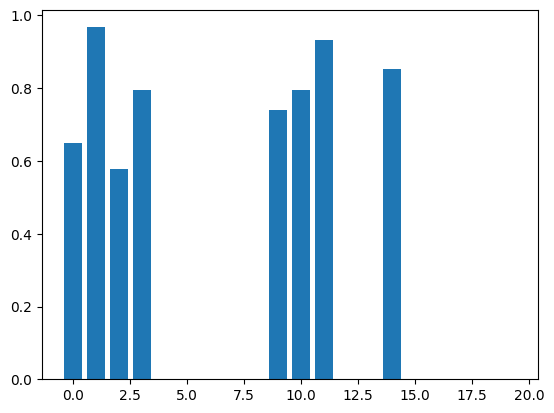

In [18]:
plt.bar(all_MIOU.keys(),all_MIOU.values());

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

first = True
for i, data in enumerate(test_loader):
    inputs, labels = data
    outputs = torch.argmax(model(inputs),dim=1)
    if first:
        predictions = torch.tensor(outputs.flatten())
        true_labels = torch.tensor(labels.flatten())
        first = False
    else:
        predictions =torch.cat((predictions,outputs.flatten() ))# Flatten the predictions
        true_labels=torch.cat((true_labels,labels.flatten() ) )# Flatten the true labels

    # Compute the confusion matrix


conf_matrix = confusion_matrix(true_labels, predictions)




C:\Users\nici9\AppData\Local\Temp\ipykernel_16784\2711694755.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions = torch.tensor(outputs.flatten())
C:\Users\nici9\AppData\Local\Temp\ipykernel_16784\2711694755.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_labels = torch.tensor(labels.flatten())


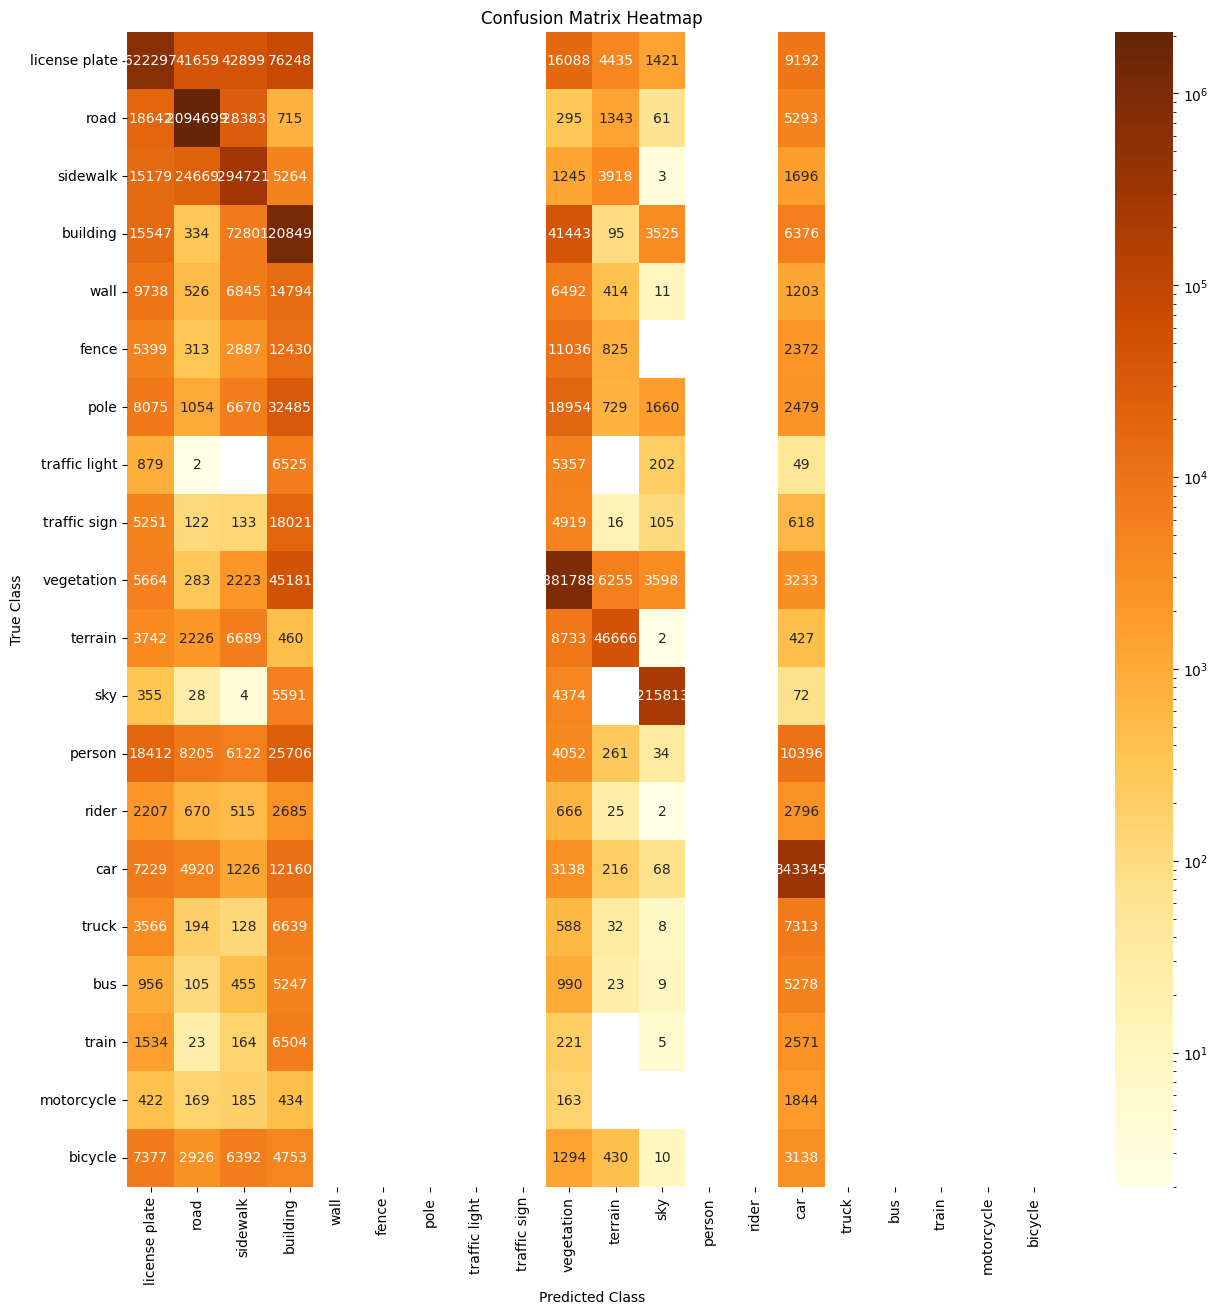

In [48]:
from matplotlib.colors import LogNorm
categories = [
  'license plate',
  'road',
  'sidewalk',
  'building',
  'wall',
  'fence',
  'pole',
  'traffic light',
  'traffic sign',
  'vegetation',
  'terrain',
  'sky',
  'person',
  'rider',
  'car',
  'truck',
  'bus',
  'train',
  'motorcycle',
  'bicycle']

# Create a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, cmap="YlOrBr" ,fmt='d',norm=LogNorm(),xticklabels = categories,yticklabels=categories)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix Heatmap")
plt.show()


In [84]:
def show_img_and_mask(img, label):
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(1, 2, 1)
    img = img.permute(1,2,0)
    plt.imshow(img * IMAGESIZE)
    fig.add_subplot(1, 2, 2)
    plt.imshow(label.permute(1,2,0))
    plt.show()
    return

torch.Size([128, 128, 3])


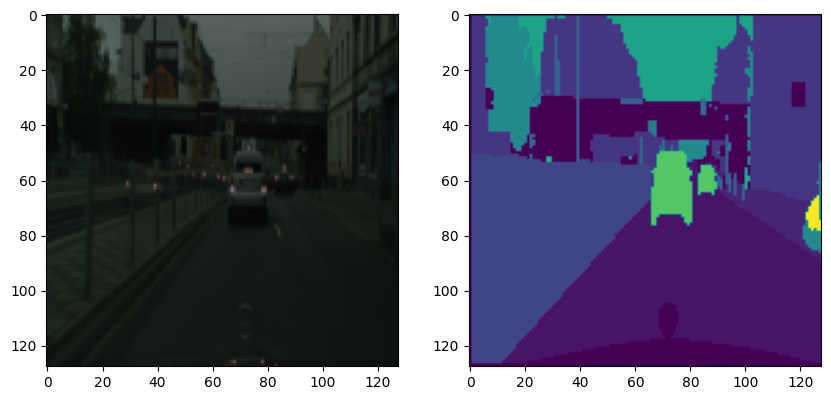

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


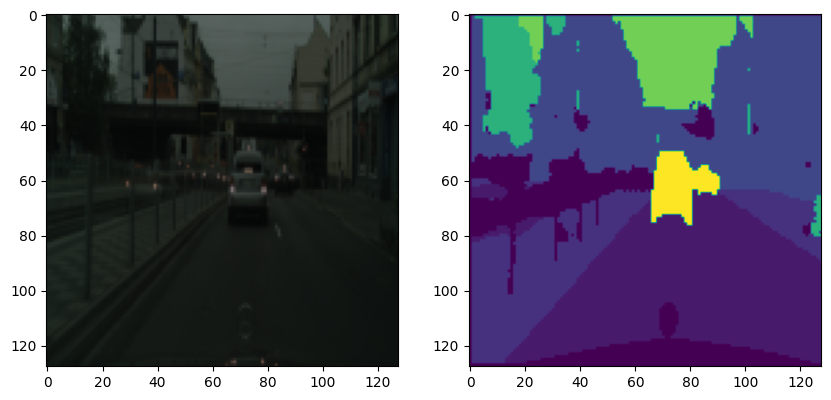

torch.Size([128, 128, 3])


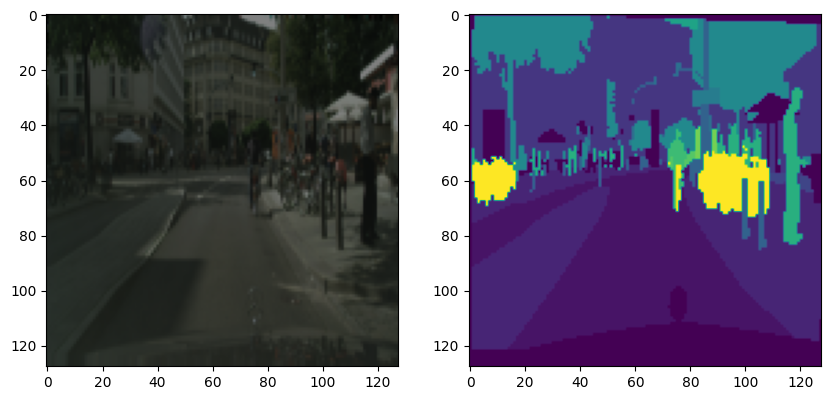

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


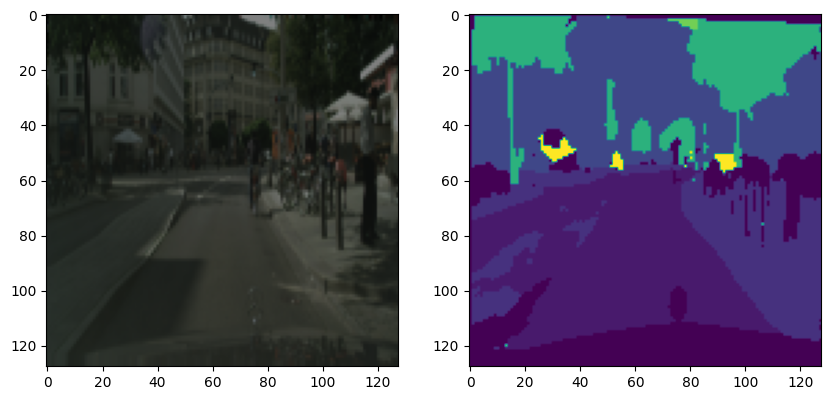

torch.Size([128, 128, 3])


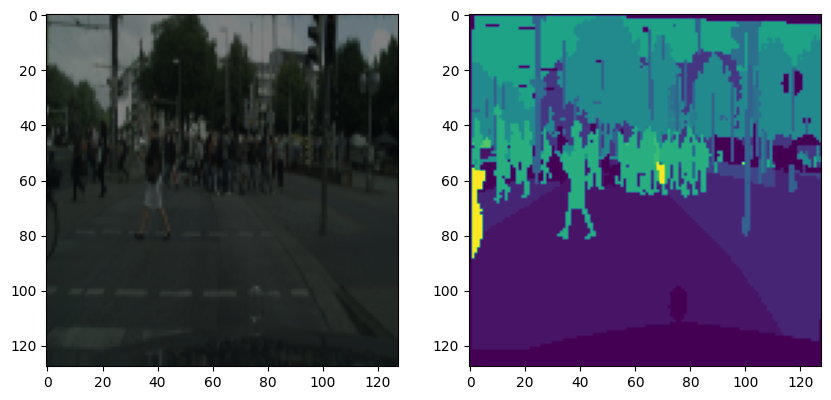

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


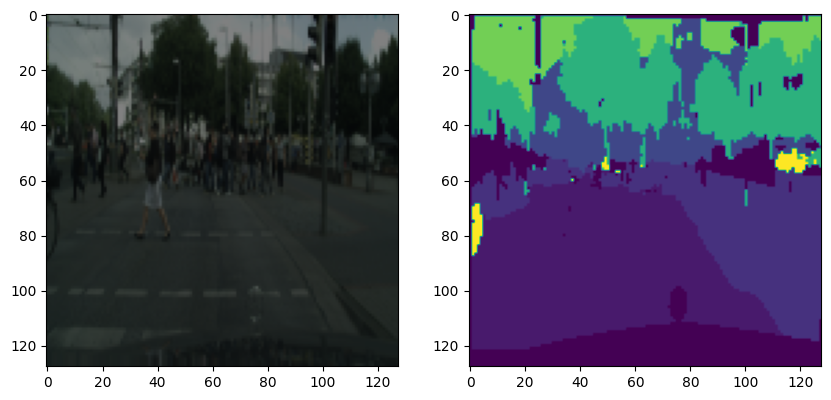

torch.Size([128, 128, 3])


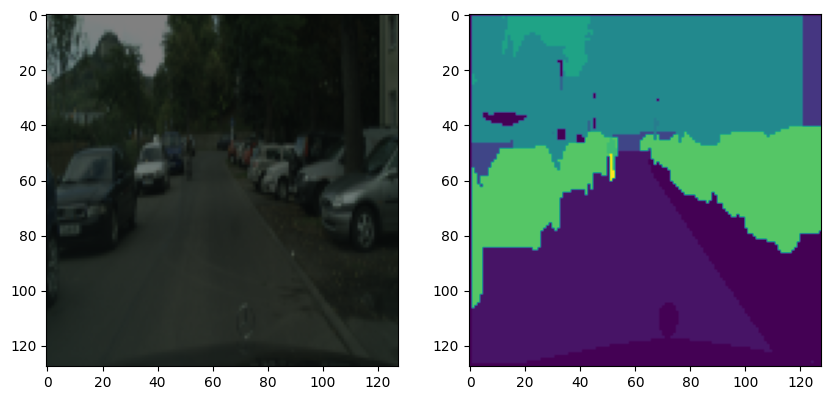

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


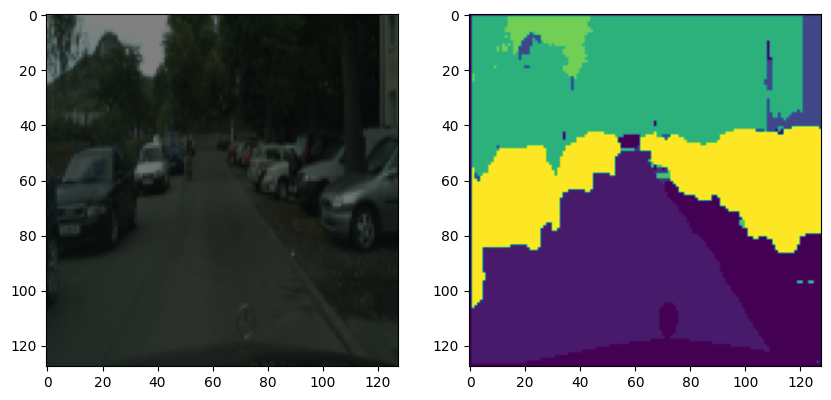

torch.Size([128, 128, 3])


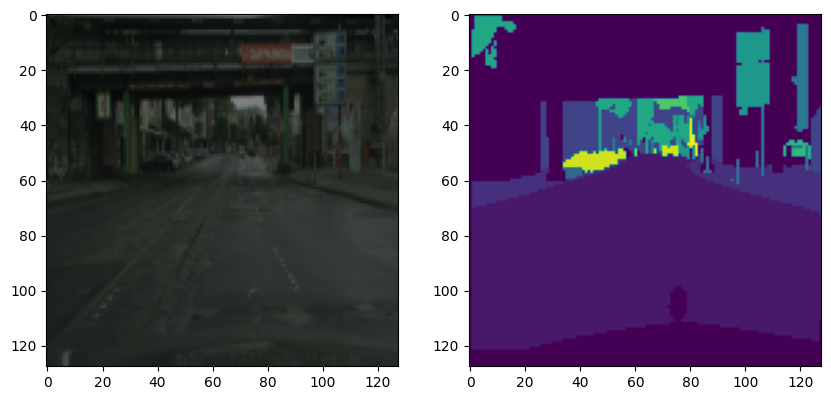

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


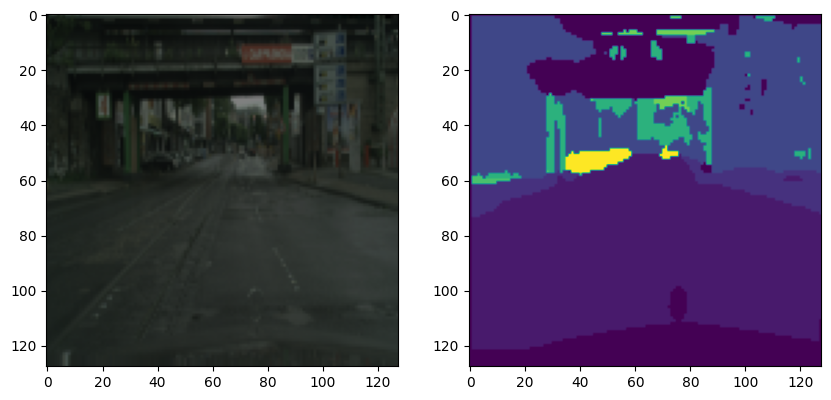

torch.Size([128, 128, 3])


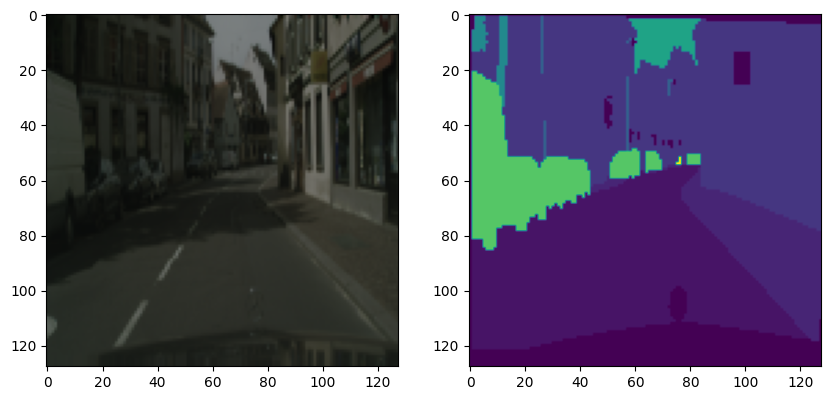

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


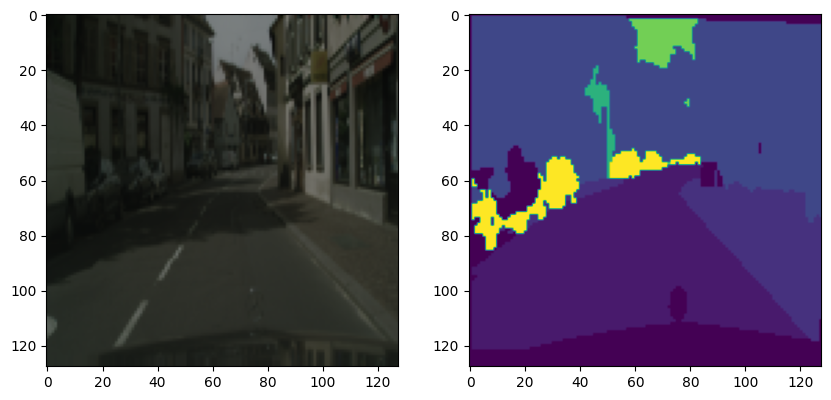

torch.Size([128, 128, 3])


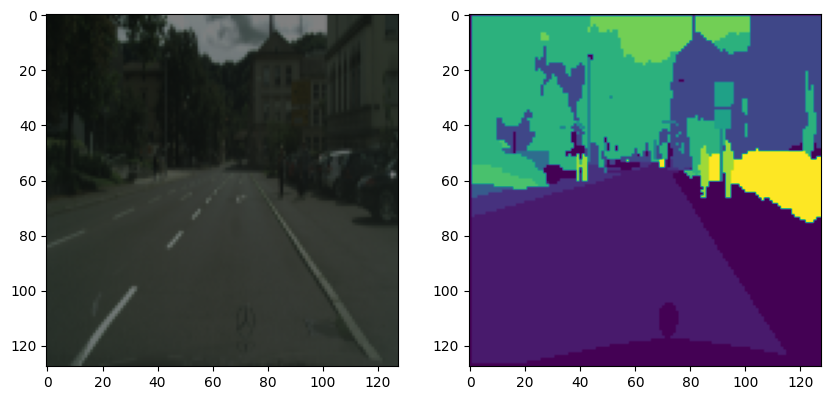

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


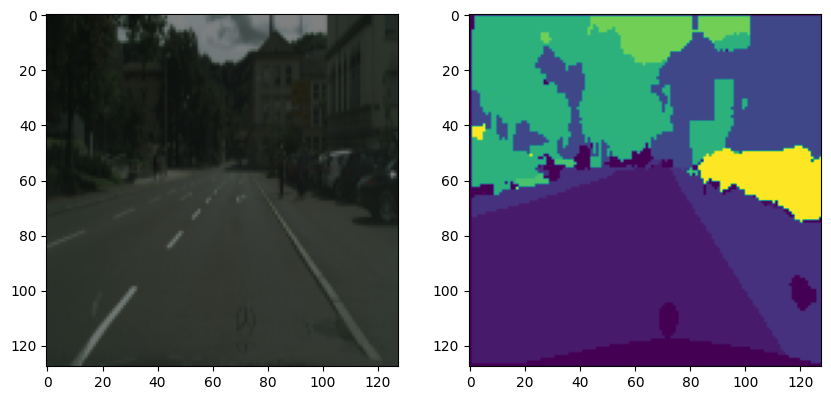

torch.Size([128, 128, 3])


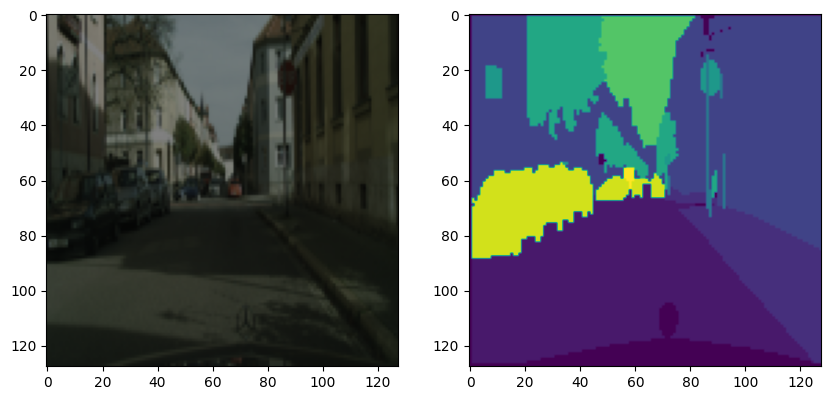

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


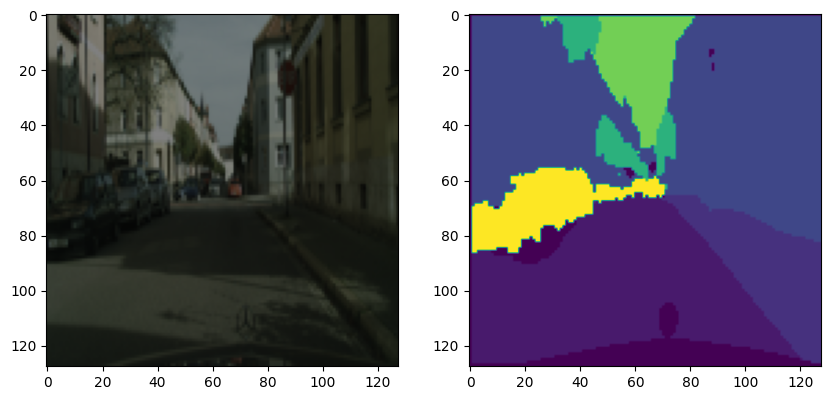

torch.Size([128, 128, 3])


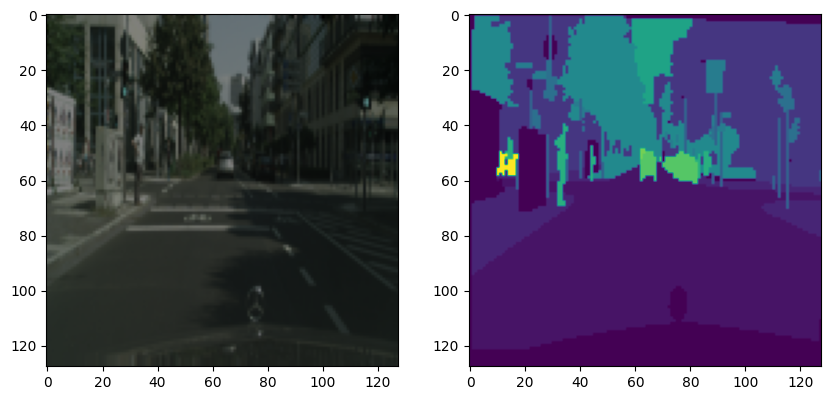

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


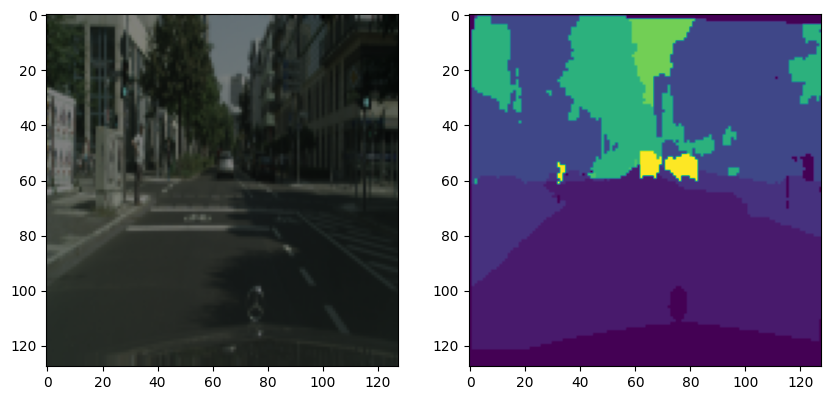

torch.Size([128, 128, 3])


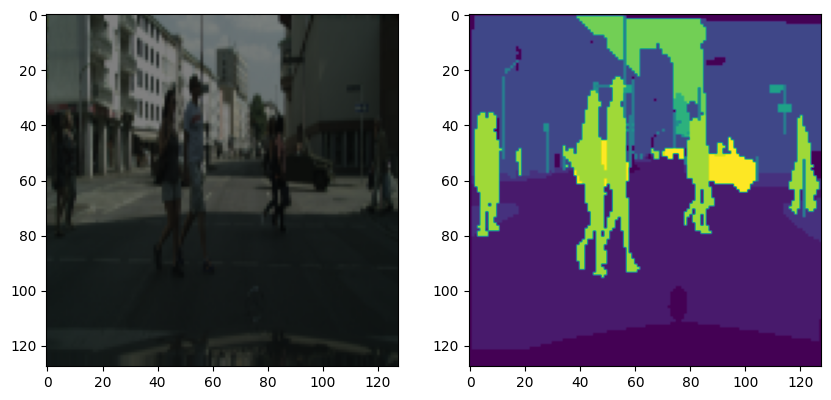

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


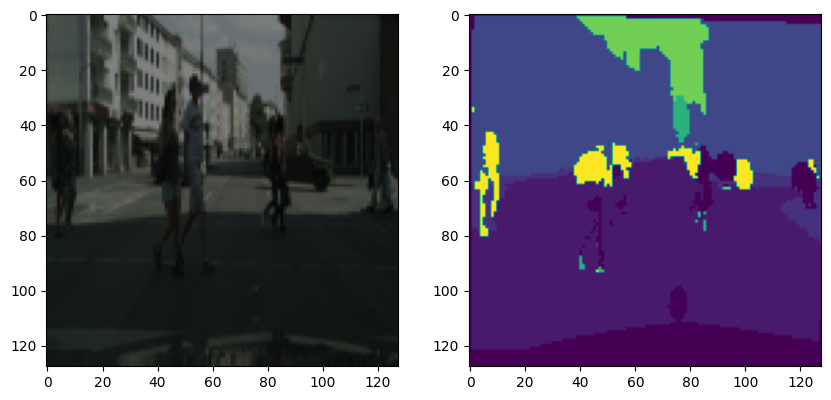

torch.Size([128, 128, 3])


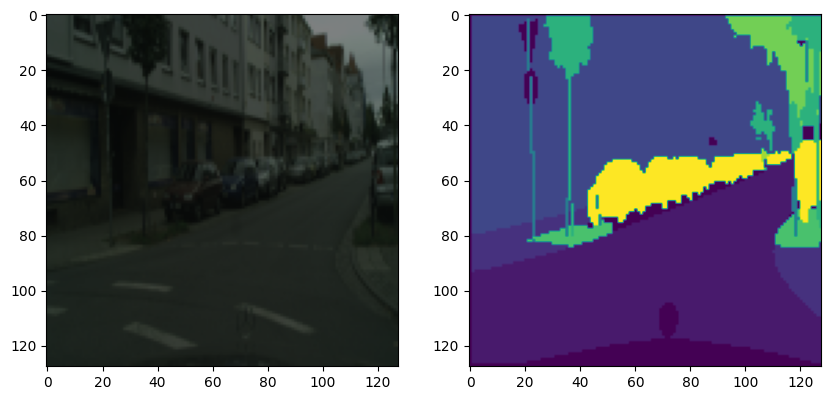

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


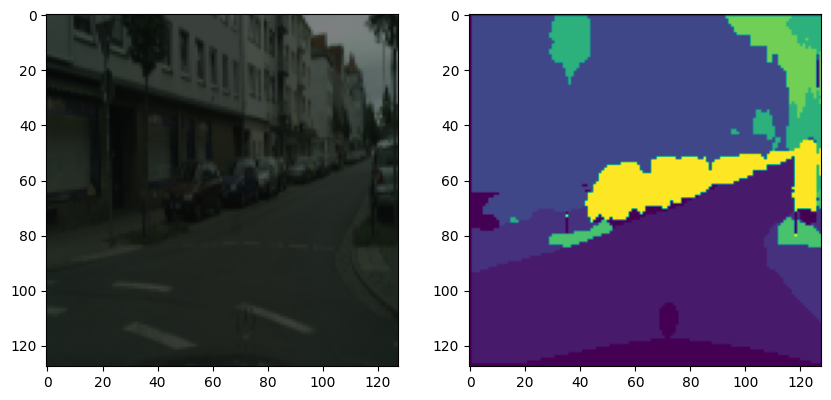

torch.Size([128, 128, 3])


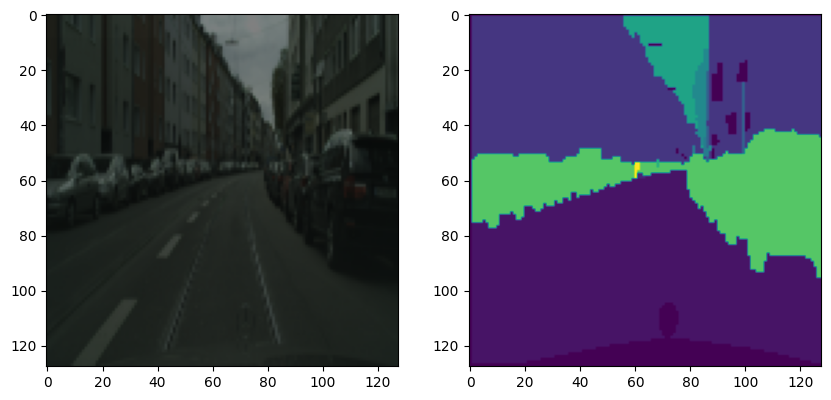

torch.Size([32, 1, 128, 128]) torch.Size([32, 128, 128])


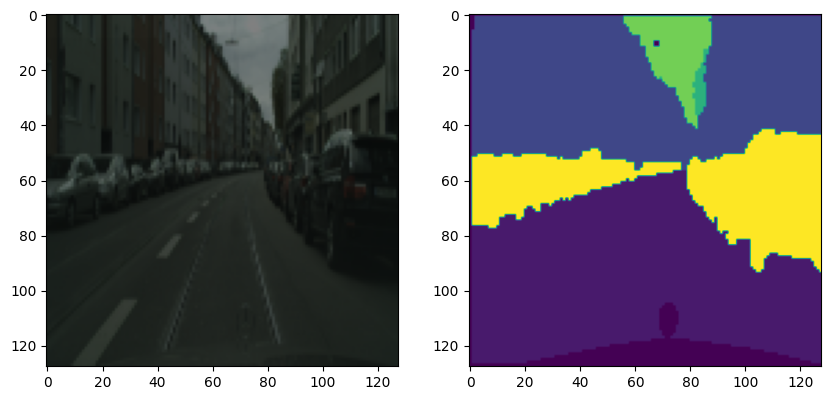

torch.Size([128, 128, 3])


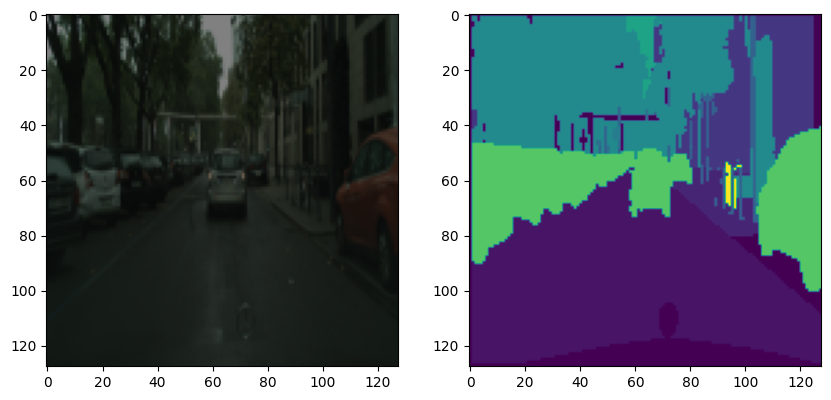

torch.Size([16, 1, 128, 128]) torch.Size([16, 128, 128])


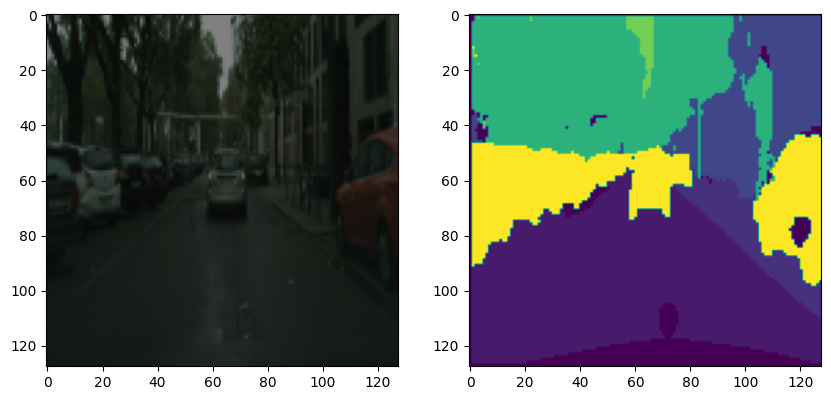

In [88]:
with torch.no_grad():
    all_MIOU = []
    images = []
    for i, data in enumerate(test_loader):
        inputs, labels = data
        outputs = torch.argmax(model(inputs),dim=1)
        print((inputs[0].permute(1,2,0)).shape)
        show_img_and_mask(inputs[0]/255,labels[0])
        print(labels.shape,outputs.shape)
        show_img_and_mask(inputs[0]/255,outputs[0].reshape([1,128,128]))


#output some images and labels and images and predicted labels 
